# Anomaly detection


## DBSCAN 
- Density-Based Spatial Clustering of Applications with Noise.
- No assumptions about distributions.
- Definitions:
    - 'Core point' if >= MinPts within radius $\epsilon$.
    - 'Border point' if < MinPts within radius $\epsilon$, but within radius of a 'core point'.
    - Else a 'Noise points'.
- Clustering:
    - Cluster 'core points' that lay within each other's radii.
    - Assign 'border points' to their respective 'core point' clusters.
- Our main interest is in detecting 'noise points', i.e., outliers.
    - Also, small clusters may be indicative of series of outliers.

### DBSCAN in 2D
- Illustration of the concept in 2D from [Wikimedia CC-SA 3.0 by Chire](https://commons.wikimedia.org/wiki/File:DBSCAN-Illustration.svg)  
<img src="../../images/DBSCAN.png" width="300px">

### DBSCAN in 1D
- To avoid a pure vertical clustering in the charts, we need to use the observation/time dimension actively.
- The horizontal spacing between points in the chart will be an extra parameter to tune.
- More than one variable can be included in DBSCAN, but these must be matched by some form of scaling, e.g., standardisation.
- DBSCAN does not care about drift in mean values, only local density (pro and con).

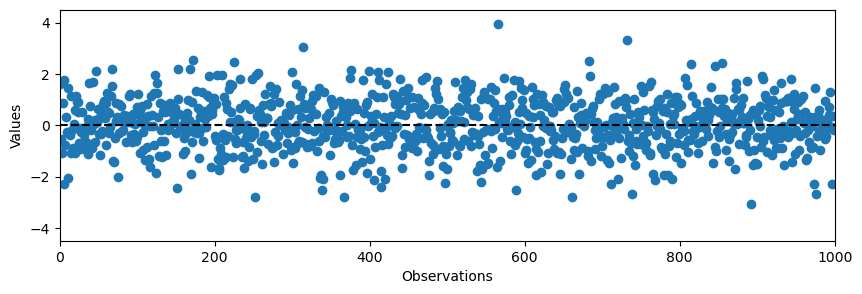

In [1]:
# Random normal data
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
data = np.random.normal(0, 1, 1000)
plt.figure(figsize=(10,3))
plt.plot(data, 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, 1000)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Values')
plt.xlabel('Observations')
plt.show()

In [2]:
# Import DBSCAN from sklearn
from sklearn.cluster import DBSCAN

# Reshape the data to a column vector together with an index column
step_size = 0.02
data2D = np.array([data, np.linspace(0, 1000*step_size, 1000)]).T

# Initialize and fit the DBscan model
db = DBSCAN(eps=0.5, min_samples=3, metric='euclidean')
db.fit(data2D)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
# -1 is an outlier, >=0 is a cluster

# Count number of samples in each cluster
counts = np.bincount(pred_labels+1)
counts

array([ 28, 957,   4,   3,   5,   3])

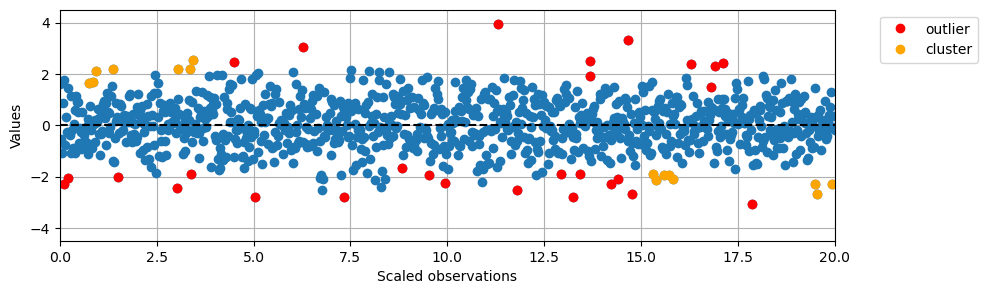

In [5]:
# Show the cluster labels
from matplotlib.lines import Line2D
plt.figure(figsize=(10,3))
plt.plot(data2D[:,1], data2D[:,0], 'o')
plt.ylim(-4.5, 4.5)
plt.xlim(0, max(data2D[:,1]))
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Values')
plt.xlabel('Scaled observations')
# Plot special samples in red and orange
for i in range(len(data)):
    if pred_labels[i] == -1:
        plt.plot(data2D[i,1], data2D[i,0], 'o', color='red')
    if pred_labels[i] > 0:
        plt.plot(data2D[i,1], data2D[i,0], 'o', color='orange')
legend_elements = [Line2D([0], [0], marker='o', color='red', label='outlier', linestyle='None'),
                   Line2D([0], [0], marker='o', color='orange', label='cluster', linestyle='None')]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.show()

In [4]:
# Convert the above plot to Plotly format
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data2D[:,1], y=data2D[:,0], mode='markers', marker=dict(color='blue'), name='normal'))
fig.add_trace(go.Scatter(x=data2D[:,1][pred_labels==-1], y=data2D[pred_labels==-1,0], mode='markers', marker=dict(color='red'), name='outlier'))
fig.add_trace(go.Scatter(x=data2D[:,1][pred_labels>0], y=data2D[pred_labels>0,0], mode='markers', marker=dict(color='orange'), name='cluster'))
fig.update_layout(title='DBSCAN Anomaly Detection', xaxis_title='Scaled observations', yaxis_title='Values')
fig.show()

### Exercise
- Look at the DEWP measurements in the Beijing pollution data (2000 timepoints).
- Try to tune a DBSCAN on the data.
- Does it work as advertised?

## Local Outlier Factor - LOF
- [Wikipedia: Local Outlier Factor](https://en.wikipedia.org/wiki/Local_outlier_factor)
- Sklearn

## Isolation Forest
- The [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm
- Implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

## Resources
-